## Import library

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score # モデル評価用(正答率)
from sklearn.metrics import log_loss # モデル評価用(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価用(auc)
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_columns',100)
pd.set_option('Display.max_rows',100)

## Import Dataset

In [3]:
# path = "../csv/df_core.csv"
# df   = pd.read_csv( path, index_col=0 )

path    = "../final_assignment_public/Telecom_customer_churn.csv"
df   = pd.read_csv( path )
df

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.000000,42.333333,0.0,45.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.000000,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.000000,132.600000,0.000000,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.000000,69.000000,0.0,193.333333,0.000000,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.000000,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.000000,75.333333,0.000000,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.000000,0.333333,0.0,6.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,5.193333,0.000000,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.000000,1.333333,0.0,3.666667,0.000000,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.000000,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.000000,3.380000,0.000000,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.000000,94.666667,0.0,137.000000,0.000000,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.000000,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.000000,173.476667,0.000000,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6

### Numerical data

In [4]:
# 数値変数を確認
numerical = df[df.select_dtypes( exclude=object ).columns]
x_num = numerical.columns

# 欠損値を0で埋める
numerical = numerical.fillna(0)
# check_null( numerical )

# 反映
df[x_num] = numerical

### Categorical data encoding

In [5]:
# カテゴリカル変数を確認
categorical = df[df.select_dtypes( include=object ).columns]
x_cat = categorical.columns

# 欠損値がある行を落とす
df_nona = df.dropna( axis=0 )

# For Categorical data, converted to numerical using Label Encoder. 
# By this method, all categorical data are sorted by alphabetically.
for x in x_cat:
    df_nona[x] = LabelEncoder().fit_transform( df_nona[x] )

In [6]:
display( df_nona )

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.0,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.000000,42.333333,0.0,45.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.000000,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.000000,132.600000,0.000000,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,1,0,0,1652,4228.00,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,2,13,3,0,149.98999,2.0,2.0,2,0.0,0.0,0,15.0,1,3,1.0,0,4.0,3.0,2,0,0.0,8,0,0,0,0,0,1,361.0,1000001
4,55.2300,570.50,71.980,0.0000,0.0,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.000000,94.666667,0.0,137.000000,0.000000,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.000000,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.000000,173.476667,0.000000,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,2,0,0,4485,14028.00,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,4,10,3,0,149.98999,6.0,4.0,2,0.0,0.0,1,5.0,0,3,1.0,0,6.0,1.0,2,14,0.0,5,0,0,0,0,0,1,434.0,1000005
9,31.6625,25.50,29.990,0.2475,0.0,0.0,0.0,0.0,0.0,59.50,4.0275,0.000000,0.0,1.000000,0.0,2.333333,0.0,6.666667,0.000000,0.000000,0.0,3.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.666667,0.000000,1.866667,0.000000,1.666667,0.0,1.933333,0.0,1.000000,6.666667,3.333333,0.0,0.000000,0,57,2,2,0,0,0,391,994.00,1458.42,1457.84,976.00,377,26.51,17.75,6.85,6,3,30,54.0,7.0,34.0,0,4,3,0,79.98999,2.0,2.0,2,0.0,0.0,0,8.0,1,2,2.0,0,9.0,2.0,5,0,1.0,8,0,0,0,0,0,1,601.0,1000010
10,62.1275,97.50,65.985,2.4750,0.0,0.0,0.0,0.0,0.0,23.50,6.8225,0.000000,0.0,0.333333,0.0,4.000000,0.0,19.333333,0.333333,0.000000,0.0,15.000000,0.333333,4.000000,98.666667,96.920000,0.000000,0.000000,136.493333,0.056667,0.000000,3.666667,15.366667,0.000000,0.000000,7.666667,0.333333,66.073333,0.056667,7.333333,0.0,70.420000,0.0,0.333333,19.666667,15.333333,0.0,0.000000,0,59,2,2,2,0,0,2392,6868.11,3290.73,3195.01,6620.11,2312,56.05,116.14,40.56,90,16,60,123.0,32.0,64.0,0,4,3,0,79.98999,3.0,3.0,2,0.0,0.0,0,15.0,1,3,5.0,0,6.0,0.0,2,0,0.0,8,1,0,0,0,0,1,464.0,1000011
12,81.0000,1056.25,75.000,0.0000,0.0,0.0,0.0,0.0,0.0,42.75,2.3500,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0,55,1,1,2,5,0,31584,51857.07,4270.87,4181.91,51553.07,31397,78.90,972.70,592.40,1042,625,80,999.0,625.0,76.0,4,6,3,0,199.98999,9.0,5.0,2,0.0,0.0,0,15.0,1,3,3.0,0,5.0,0.0,1,0,0.0,6,0,0,0,0,0,1,388.0,1000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Train Test Split

In [8]:
df_train, df_test = train_test_split( df_nona, test_size=0.2, random_state=4 )

print( 'df_train: {}'.format( len(df_train) ) )
print( 'df_test : {}'.format( len(df_test) ) )

df_train: 29989
df_test : 7498


In [9]:
# trainデータを説明変数(X_train)と目的変数(y_train)に分割
X_train = df_train.drop( 'churn', axis=1 )
y_train = df_train['churn']
 
# testデータを説明変数(X_test)と目的変数(y_test)に分割
X_test  = df_test.drop( 'churn', axis=1 )
y_test  = df_test['churn']

## Train & Predict

In [21]:
# LightGBM model
model = LGBMClassifier(
        boosting_type='gbdt', 
        class_weight='balanced',
        max_depth=15,
        num_iteration=1000,
        num_threads=1 )

In [22]:
# 学習
model.fit( X_train, y_train )

[LightGBM] [Warning] num_iterations is set=1000, num_iteration=1000 will be ignored. Current value: num_iterations=1000
[LightGBM] [Warning] num_threads is set=1, n_jobs=-1 will be ignored. Current value: num_threads=1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


LGBMClassifier(class_weight='balanced', max_depth=15, num_iteration=1000,
               num_threads=1)

In [28]:
# 予測
y_pred = model.predict( X_test )
y_pred_prob = model.predict_proba( X_test ) # テストデータのクラス予測確率を返す

## Evaluate the model

In [30]:
# 真値と予測値の表示
df_pred = pd.DataFrame( {'churn_GT':y_test, 'churn_pred':y_pred} )
display( df_pred )

# 真値と予測確率の表示
df_pred_prob = pd.DataFrame( {'churn_GT':y_test, '0_prob':y_pred_prob[:,0], '1_prob':y_pred_prob[:,1]})
display( df_pred_prob )

,churn_GT,churn_pred
87800,0,1
91222,0,0
52277,1,0
57399,1,1
41193,1,0
...,...,...
44592,1,0
54296,0,0
62330,1,1
58015,0,1


,churn_GT,0_pred,1_prob
87800,0,0.494926,0.505074
91222,0,0.929634,0.070366
52277,1,0.550917,0.449083
57399,1,0.055597,0.944403
41193,1,0.798945,0.201055
...,...,...,...
44592,1,0.614789,0.385211
54296,0,0.587723,0.412277
62330,1,0.447927,0.552073
58015,0,0.355441,0.644559


In [35]:
# モデル評価
# acc: 正答率
acc     = accuracy_score( y_test, y_pred )
print( 'Acc:\t', acc )

# logloss 
logloss = log_loss( y_test, y_pred_prob ) # 引数 : log_loss(正解クラス,[クラス0の予測確率,クラス1の予測確率])
print( 'logloss:', logloss )

# AUC 
auc     = roc_auc_score( y_test,y_pred_prob[:,1]) # 引数 : roc_auc_score(正解クラス, クラス1の予測確率)
print( 'AUC:\t', auc )

Acc:	 0.6308348893038144
logloss: 0.6642154590271643
AUC:	 0.6801837577889996


In [43]:
# ROC曲線の描画
# cf : https://tips-memo.com/python-roc
from sklearn import metrics
from sklearn.metrics import roc_curve

def plot_roc_curve():
    plt.rcParams["figure.figsize"] = (10, 8)
    
    fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])
    auc = metrics.auc(fpr, tpr)
    plt.plot( fpr, tpr, label='ROC curve (area = %.2f)'%auc, color='black' )
    plt.legend()
    plt.xlabel( 'FPR: False positive rate' )
    plt.ylabel( 'TPR: True positive rate' )
    # plt.grid()
    plt.show()

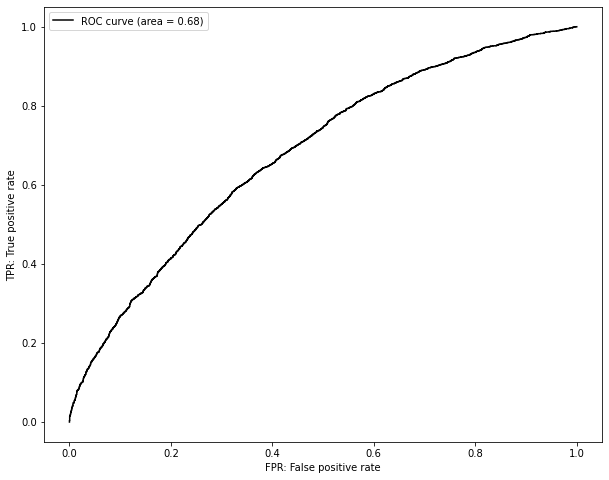

In [44]:
plot_roc_curve()

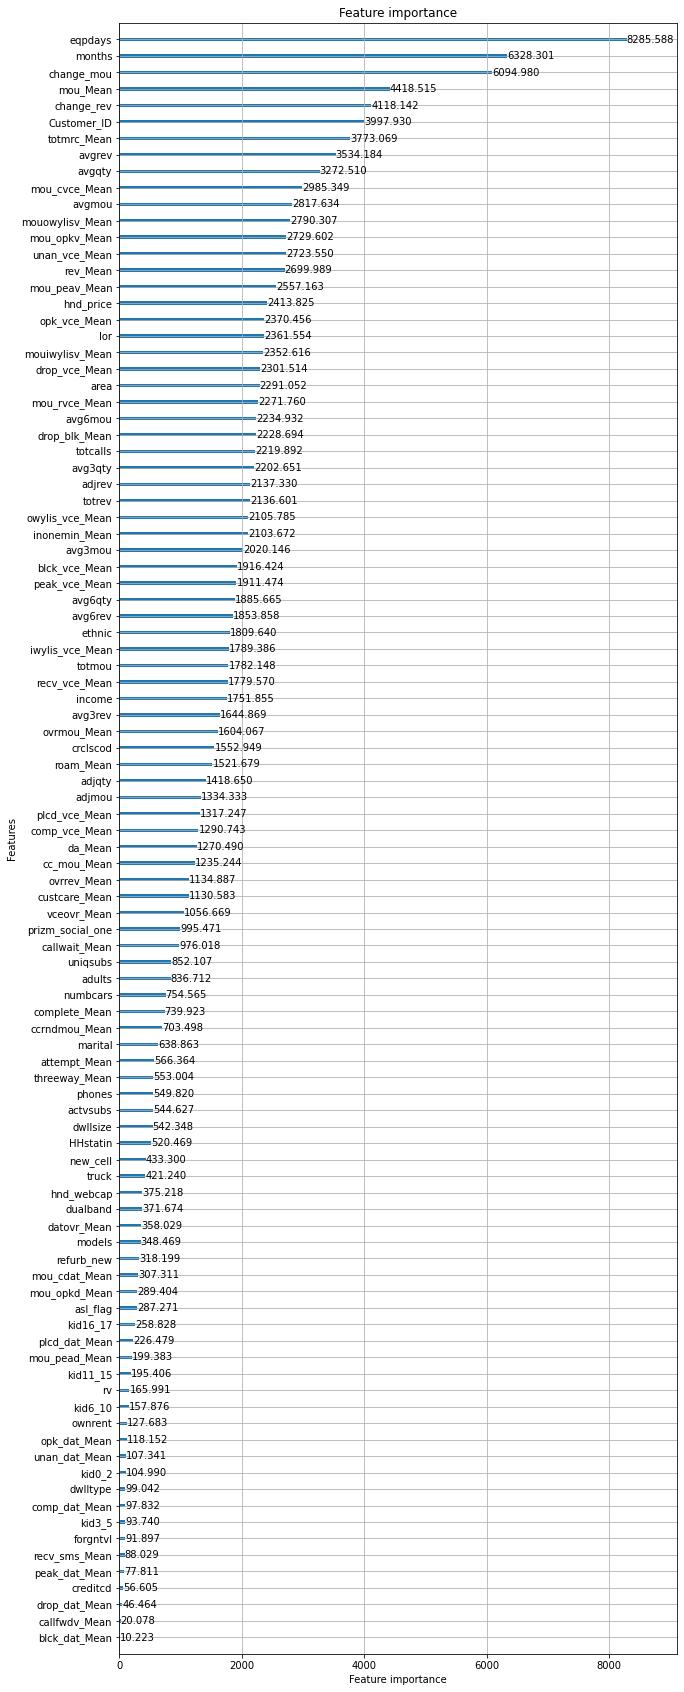

In [48]:
lgbm.plot_importance( model, importance_type="gain", max_num_features=100, figsize=(10, 30) )